# Stochastic Optimization
## Project: Comparaison between Stochastic Gradient Descent and Adam
*Badis Jaouani - M2 Statistics*
___

This notebook contains the numerical simulations appearing in the main document. The algorthms are tested on MNIST data set, on which the task is to predict wether the digit is 0 or not (binary classification), as well as on simulated data. We are going to train a linear Support Vector Machine as well as a Logistic Regression Classifier and a Neural Network.  


# Contents
___
1. [Import data & Preprocessing](#Import)
2. [SGD vs. Adam for training a linear SVM classifier](#Import)
3. [SGD vs. Adam for training a Logistic Regression Classifier on simulated data set](#Import)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
%config InlineBackend.figure_format = 'retina'

# 1. Import data & Preprocessing
___
We start by importing the data on which the algorithms will be run.

In [2]:
train = pd.read_csv('mnist_train.csv', header = None)
test = pd.read_csv('mnist_test.csv', header = None)

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We check if there is some missing data.

In [4]:
def missing(df):
    miss = (df.isnull().count() - df.count()).sort_values(ascending = False)
    perc = miss / df.isnull().count()
    data_missing = pd.concat([miss, perc], axis = 1, keys = ['total', 'percentage'])
    print(data_missing[data_missing.percentage>0], '\n')

In [5]:
missing(train)
missing(test)

Empty DataFrame
Columns: [total, percentage]
Index: [] 

Empty DataFrame
Columns: [total, percentage]
Index: [] 



We rescale the data so we can use it efficiently with the considered algorithms.

In [6]:
X_train = train.loc[:,1:]
y_train = train.loc[:,0]

In [7]:
X_test = test.loc[:,1:]
y_test = test.loc[:,0]

In [8]:
# Scaling 
X_train /= 255
X_test /= 255

The data is already spli into train & test sets, we just have to convert it into Numpy arrays so we can perform matrix operations on it.

In [9]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [10]:
# Data shapes
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = X_train.shape[1]

print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


Finally, the problem is converted into binary classification 0 vs. other digits.

In [11]:
for i in range(n_train):
    if y_train[i] == 0: y_train[i] = 1
    else: y_train[i] = -1

for i in range(n_test):
    if y_test[i] == 0: y_test[i] = 1
    else: y_test[i] = -1

Once the preprocessing steps are done, we are ready to implement the optimization algorithms that will be used to train our classifiers.

# 2. SGD vs. Adam for training a linear SVM classifier
___
We start by computing the hinge loss
$$
\mathcal{L}(x,y, \theta) = \sum_{(x,y) \in \mathcal{D}} max\left(0, y\,(1 - x^T\theta)\right)
$$
and its gradient, the functions `hinge_loss` and `inst_gradient` will do the task.

In [12]:
def hinge_loss(x, a, b, lamda):
    'a: data matrix'
    'b: labels'
    cost = 1 - b * (a.dot(x)) 
    cost[cost < 0] = 0
    loss = np.mean(cost) 
    return loss + lamda/2 * np.linalg.norm(x)**2

In [13]:
def inst_gradient(x, a, b, lamda):
    'Gradient at iteration t'
    'Calculated only with one observation'
    thd = b * (a.dot(x))
    gd = - b * a
    gd[thd > 1] = 0
    return gd + lamda * x

We are now ready to implement the first algorithm, the SGD. The learning rate for this algorithm is decreasing at a rate of $1/t$ and the hinge loss is computed at each gradient iteration.

In [14]:
def stoch_gradient_descent(a, b , cost, grad, epoch, lamda, eta):
    'epoch = T: number of iterations'
    'eta = 1 / (lamda*t)'

    # Initializations (same as Adam)
    x = init
    cost = np.zeros(epoch)
    cost[0] = hinge_loss(x, a, b, lamda)
    
    # Random Sampling
    a = X_sample
    b = y_sample 
    x_iter = np.zeros((a.shape[1], epoch+1))
    
    # Recursion
    for t in range(1,epoch):
        
        # Update learning rate
        eta = 1 / (lamda * t)
        
        # Update parameters 
        x -= eta * grad(x, a[t,:], b[t], lamda)
        x_iter[:,t] = x
        
        # Compute the loss
        cost[t] = hinge_loss(x, a, b, lamda)
        
    # Return the average parameters
    x_f = x_iter.mean(axis = 1)
    return x_iter, x_f, cost

Now it's Adam's turn to be implemented. We only keep the adaptive update of the learning rate. The parameter `eps` is used to ensure numerical stability. The parameters $\beta_1$ and $\beta_2$ are chosen according to (Kingma \& Ba, 2015)'s original paper.

In [15]:
def Adam(X, y, loss, grad, lamda, epoch, lr = .001, beta1 = .9, beta2 = .9999, eps = 1e-8):
    d = X.shape[1]

    # Initializations
    theta_iter = np.zeros((d,epoch))
    theta, cost = np.random.randn(d), np.zeros(epoch)
    init  = theta
    cost[0] = hinge_loss(init, X_train, y_train, lamda)
    m, v = np.zeros(d), np.zeros(d)
    
    # Random sampling
    idx = np.random.randint(0, X.shape[0], epoch)
    X = X[idx,:]
    y = y[idx]
    
    # Recursion
    for t in range(1, epoch):
        #lr /= np.sqrt(t)
        
        # Update biased moments
        m = beta1*m + (1-beta1)*inst_gradient(theta, X[t,:], y[t], lamda)
        v = beta2*v + (1-beta2)*inst_gradient(theta, X[t,:], y[t], lamda)**2
        
        # Compute unbiased moments 
        hat_m = m / (1 - beta1**t)
        hat_v = v / (1 - beta2**t)
    
        # Update parameters
        theta = theta - lr*hat_m / (np.sqrt(hat_v) + eps)
        theta_iter[:,t] = theta
        
        # Compute cost function
        cost[t] = hinge_loss(theta, X, y, lamda)

    return theta_iter, theta, cost, init, X, y

Before training the SVM on MNIST data set, we fix the desired parameters that will be used for both algorithms, including the number of iterations, the learning rate and the regularization parameter $\lambda$, that we try to keep as low as possible.

In [16]:
# Parameters
epochs = 5000
alpha = 0.01
lamda = 0.001

We now start the training.

In [17]:
# Adam
theta_iter, theta_f, cost_adam, init, X_sample, y_sample = Adam(X_train, y_train,
                                                                hinge_loss, inst_gradient,
                                                                lamda = lamda, epoch = epochs,
                                                                lr = alpha)

In [18]:
liss_adam, liss_cost_adam = [], []
iterations_adam = np.arange(0, epochs,20)
for i in iterations_adam:
    tstt_adam = y_test * X_test.dot(theta_iter[:,i])
    liss_adam.append(tstt_adam[tstt_adam>0].shape[0]/y_test.shape[0])
    liss_cost_adam.append(cost_adam[i])

In [19]:
# SGD
x_iter_sgd, x_sgd, cost_sgd = stoch_gradient_descent(X_train, y_train, 
                                                    hinge_loss, inst_gradient, 
                                                    epochs, lamda, alpha)

In [20]:
liss_sgd, liss_cost_sgd = [], []
iterations_sgd = np.arange(0,epochs, 20)
for i in iterations_sgd:
    tstt_sgd = y_test * (X_test.dot(x_iter_sgd[:,i]))
    liss_sgd.append(tstt_sgd[tstt_sgd>0].shape[0]/y_test.shape[0])
    liss_cost_sgd.append(cost_sgd[i])

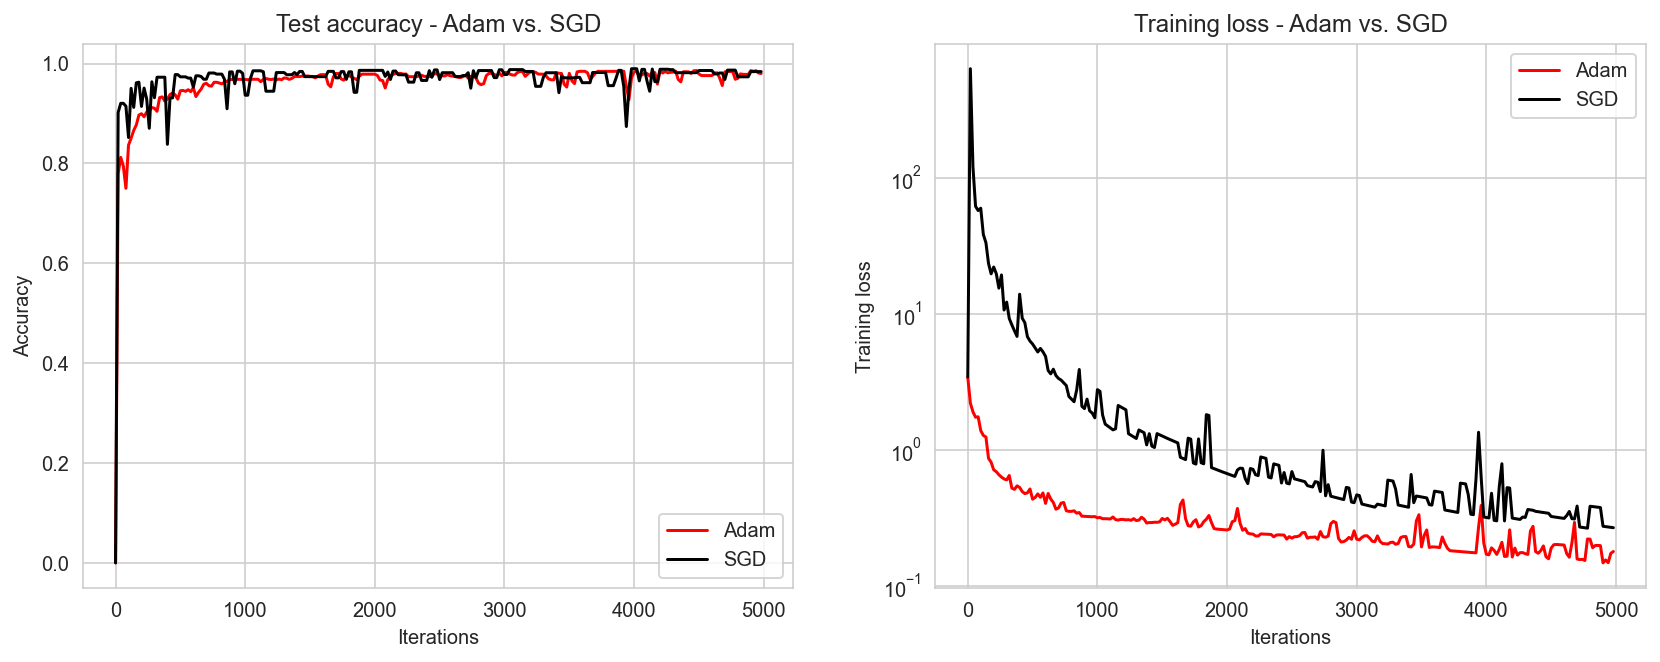

In [21]:
fig = plt.figure(figsize = (14,5))

# Accuracy
plt.subplot(121)
plt.plot(iterations_adam, liss_adam, color = 'red', label = 'Adam')
plt.plot(iterations_sgd, liss_sgd, color = 'black', label = 'SGD')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Test accuracy - Adam vs. SGD');


# Cost function
plt.subplot(122)
plt.plot(iterations_adam, liss_cost_adam, color = 'red', label = 'Adam')
plt.plot(iterations_sgd, liss_cost_sgd, color = 'black', label = 'SGD')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Training loss - Adam vs. SGD');

plt.savefig('fig.jpg')

All the figures along with the comments can be found in the document that comes with this notebook. Here, we just focus on the results. 

The next section is about simulating a data set according to a logistic model with a fixed set of parameters $\theta^*$, the objective is to train a logitic regression classifier and use the Optimization algorithms (SGD and Adam) to approximate $\theta^*$ with the sequence $(\theta_t)_{t\in \{1,...,T\}}$.

# 3. SGD vs. Adam for training a Logistic Regression Classifier on simulated data set
___
The first step is to simulate the data set. We fix the number of samples to $n = 10000$ and the number of parameters (dimensionality of the problem to $p=5$. The parameter vector to be approximated is 
$$
\theta^* = (-2,-1,0,1,2, 5, 8, 9, 5, 0.2, 0.5, 0.8, 1.2, 5.9, 6.2)
$$
The code below does the simulation of the data set.

In [22]:
theta_star = np.array([-2,-1,0,1,2, 5, 8, 9, 5, 0.2, 0.5, 0.8, 1.2, 5.9, 6.2])
p = theta_star.shape[0]
n = 10000

For the logistic model we have to compute the gradient of the loss function, that will be used to update the parameters $\theta_t$. The gradient is the following:
$$
\nabla \mathcal{L}(x,y, \theta) = \left(Sigmoid(x^T\theta) - y\right)x
$$
The functions `sigmoid` and `grad_log_inst` do the work.

In [23]:
# Instantaneous Gradient (logistic model)
def sigmoid(x):
    return np.exp(x) / (1+np.exp(x))

def grad_log_inst(theta, x, y):
    return (sigmoid(x.dot(theta)) - y)*x 

In [24]:
X = np.random.multivariate_normal(np.zeros(p), np.eye(p), size = n)
Y = np.random.binomial(n = 1, p = sigmoid(theta_star.T.dot(X.T)), size = n)

In [25]:
print(Y.shape, X.shape)

(10000,) (10000, 15)


In [26]:
# Index for plotting
idx = np.arange(0,n,1)

We use the same initial parameters for both algorithms, in order to have a fair comparaison.

In [27]:
init = np.random.normal(0,1,size = p)

Here, we compute two versions of the Stochastic Gradient Descent: the base SGD and the SGD with Nesterov acceleration.

In [28]:
# Accelerated Stochastic Gradient Descent
def asgd(m, alpha, grad):

    # Initializations
    err, err_bar = [], []
    m_bar = m
    
    # Recursion
    for i in range(X.shape[0]):
        # MSE
        err.append(np.mean(np.sum((theta_star - m)**2)))
        err_bar.append(np.mean((np.sum((theta_star - m_bar)**2))))
       
        # Update
        gamma = 1/(i+1)**alpha
        m = m - gamma * grad(m, X[i,:], Y[i])
        m_bar = m_bar + 1/(i+2) * (m - m_bar)
    return err, err_bar

The following code implements the modified Adam, so tha we can use it for this particular Logistic Regression setting. The main difference is replacing the loss function with the Mean Squared Error between $\theta^*$ and $\theta_t$.

In [29]:
def AdamLogReg(X, y, grad, lr = .1, beta1 = .9, beta2 = .9999, eps = 1e-8):
    d = X.shape[1]
    p = X.shape[0]
    
    # Initializations
    theta_iter = np.zeros((d,p))
    theta, err = init, np.zeros(p)
    err[0] = np.mean((theta-theta_star)**2)
    m, v = np.zeros(d), np.zeros(d)
    
    # Recursion
    for t in range(1, p):
        #lr /= np.sqrt(t)
        
        # Update biased moments
        m = beta1*m + (1-beta1)*grad(theta, X[t,:], y[t])
        v = beta2*v + (1-beta2)*grad(theta, X[t,:], y[t])**2
        
        # Compute unbiased moments 
        hat_m = m / (1 - beta1**t)
        hat_v = v / (1 - beta2**t)
    
        # Update parameters
        theta = theta - lr*hat_m / (np.sqrt(hat_v) + eps)
        theta_iter[:,t] = theta
        
        # Compute cost function
        err[t] = np.mean((theta - theta_star)**2)

    return theta_iter, theta, err

We also fix the learning rate, for Adam.

In [30]:
# Parameters
alpha = 0.05

We are ready to start the training.

In [31]:
# Adam
theta_iter, theta_f, cost_adam = AdamLogReg(X, Y,
                                           grad_log_inst,
                                           lr = alpha)

In [32]:
# SGD & Accelerated SGD
err, err_bar = asgd(init, 0.2, grad = grad_log_inst)

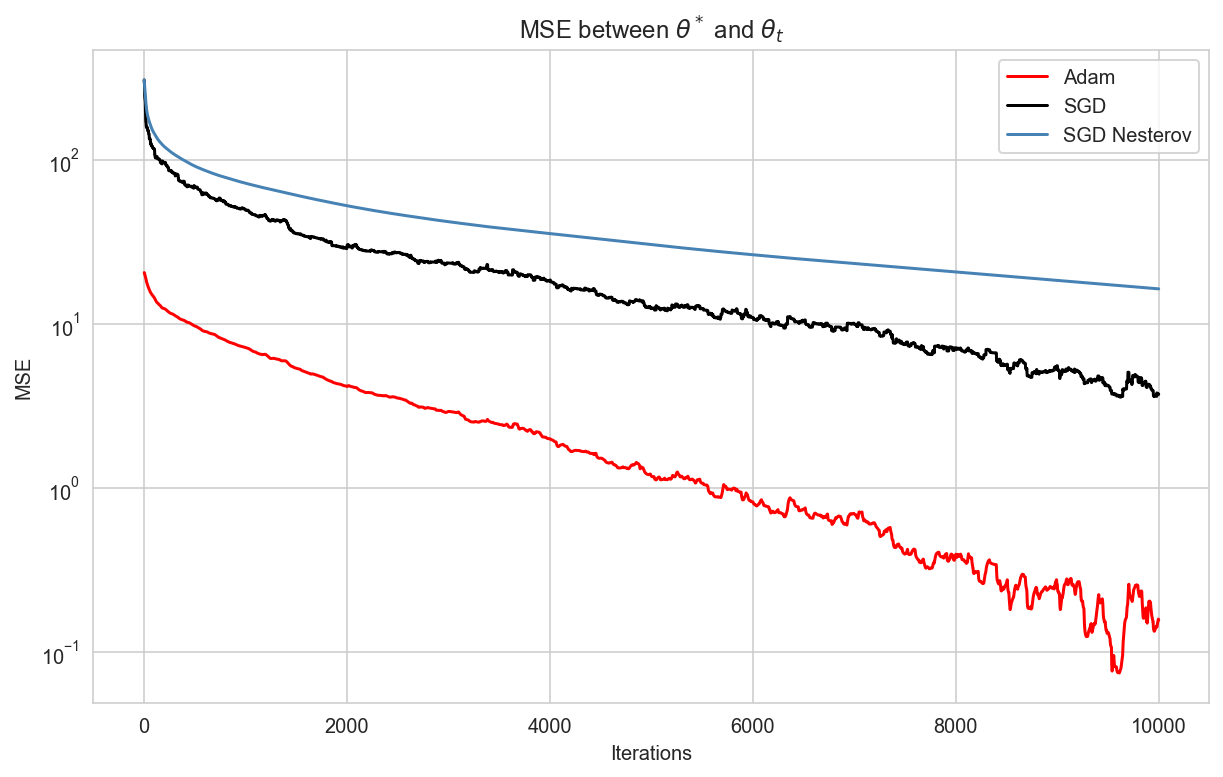

In [33]:
plt.figure(figsize = (10,6))
plt.plot(cost_adam, label = 'Adam', color = 'red')
plt.plot(err, label = 'SGD', color = 'black')
plt.plot(err_bar, label = 'SGD Nesterov', color = 'steelblue')
plt.yscale('log')
plt.title(r'MSE between $\theta^*$ and $\theta_t$')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend();

Again, the figure is commented on the main document.

# References
___
Diederik P. Kingma, Jimmy Lei Ba (2015): *ADAM: A Method for Stochastic Optimiza-tion.* , SarXiv:1412.6980v9 [cs.LG] 30 Jan 2017.

Duchi, John / Hazan, Elad / Singer, Yoram (2011): *Adaptive Subgradient Methods forOnline Learning and Stochastic Optimization.* , Journal of Machine Learning Research12 (2011) 2121-2159.

Hazan,  Elad  (2019): *Introduction  to  Online  Convex  Optimization.*  ,  arXiv:1909.05207[cs.LG], 2019.

Tijmen Tieleman, Geoffrey Hinton (2012): *Lecture 6.5 - RMSProp, COURSERA: NeuralNetworks for Machine Learning.* , Technical report (2012).

Wintenberger, Olivier (2020): *Online Convex Optimization.* , Sorbonne Universit ́e, 2020.

Zinkevic,  Martin  (2003): *Online  Convex  Programming  and  Generalized  InfinitesimalGradient Ascent.* , Proceedings of the Twentieth International Conference on MachineLearning (ICML-2003), Washington DC, 2003